# Исследовательский анализ данных
## Riiid Answer Correctness Prediction

Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

### train.csv
Описание данных:

 - ***row_id:*** (int64) ID идентификатор строки.

 - ***timestamp:*** (int64) время в миллисекундах между этим взаимодействием с пользователем и первым завершением события от этого пользователя.

 - ***user_id:*** (int32) ID код для пользователя.

 - ***content_id:*** (int16) ID код для взаимодействия с пользователем.

 - ***content_type_id:*** (int8) 
0, если событием был вопрос, заданный пользователю, 1, если событием был просмотр пользователем лекции.

 - ***task_container_id:*** (int16) Id Идентификатор пакета вопросов или лекций. Например, пользователь может увидеть три вопроса подряд, прежде чем увидеть объяснения к любому из них. Все эти трое будут иметь общий идентификатор Task_container_id.

 - ***user_answer:*** (int8) ответ пользователя на вопрос, если таковой имеется. Для лекций прочтите -1 как ноль.

 - ***answered_correctly:*** (int8) если пользователь ответил правильно. Для лекций прочтите -1 как ноль.

 - ***prior_question_elapsed_time:*** (float32) Среднее время в миллисекундах, которое потребовалось пользователю для ответа на каждый вопрос из предыдущей группы вопросов, игнорируя любые промежуточные лекции. Имеет значение NULL для первого пакета вопросов или лекции пользователя. Обратите внимание, что время — это среднее время, которое пользователь потратил на решение каждого вопроса в предыдущем пакете.

 - ***prior_question_had_explanation:*** (bool) Увидел ли пользователь объяснение и правильный ответ(ы) после ответа на предыдущий блок вопросов, игнорируя любые лекции между ними. Значение распределяется по одному пакету вопросов и равно нулю для первого пакета вопросов или лекции пользователя. Обычно первые несколько вопросов, которые видит пользователь, были частью вводного диагностического теста, по которому он не получил никакой обратной связи.

### questions.csv: 

метаданные по вопросам, задаваемым пользователям.

 - ***question_id:*** внешний ключ для столбца content_id поезда/теста, когда тип контента — вопрос (0).
Bundle_id: код, для которого вопросы подаются вместе.

 - ***correct_answer:*** ответ на вопрос. Можно сравнить со столбцом train user_answer, чтобы проверить, был ли прав пользователь..

 - ***part:*** соответствующий раздел теста TOEIC.

 - ***tags:*** один или несколько подробных кодов тегов для вопроса. Значение тегов не будет указано, но этих кодов достаточно для группировки вопросов.

### example_test_rows.csv 

Три выборочные группы данных набора тестов в том виде, в котором они будут доставлены API временных рядов. Формат во многом такой же, как и train.csv. Есть два разных столбца, которые отражают, какая информация фактически доступна инструктору по искусственному интеллекту в любой момент времени, но при этом взаимодействия с пользователем сгруппированы вместе ради производительности API, а не строго отображают информацию для одного пользователя за раз. Некоторые пользователи появятся в скрытом тестовом наборе, которые НЕ были представлены в наборе поездов, имитируя задачу быстрой адаптации к моделированию новых поступлений на веб-сайт.


 - ***prior_group_responses*** (string) предоставляет все записи user_ответ для предыдущей группы в строковом представлении списка в первой строке группы. Все остальные строки в каждой группе имеют значение NULL. Если вы используете Python, вам, скорее всего, захочется вызвать eval для строк, отличных от NULL. Некоторые строки могут быть нулевыми или пустыми списками.

 - ***prior_group_answers_correct*** (string) предоставляет все поля Answer_correctly для предыдущей группы в том же формате и с оговорками, что и Prior_group_responses. Некоторые строки могут быть нулевыми или пустыми списками.

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from phik import phik_matrix

In [2]:
pd.__version__

'2.1.4'

### Загрузка данных

In [3]:
train = pd.read_csv('./data/train.csv')

In [4]:
questions = pd.read_csv('./data/questions.csv')

In [5]:
lectures = pd.read_csv('./data/lectures.csv')

### Ознакомление с данными

In [6]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [7]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [8]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [9]:
train.shape

(101230332, 10)

In [10]:
questions.shape

(13523, 5)

In [11]:
lectures.shape

(418, 4)

### Предобработка данных

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


In [13]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [14]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


***преобразование данных из int64 в int32*** 

object в bool


для уменьшения размера наборов данных ***train***

In [15]:
# Уменьшение типов данных в train
train['row_id'] = train['row_id'].astype('int32')
train['timestamp'] = train['timestamp'].astype('int32')
train['user_id'] = train['user_id'].astype('int32')
train['content_id'] = train['content_id'].astype('int16')
train['content_type_id'] = train['content_type_id'].astype('int8')
train['task_container_id'] = train['task_container_id'].astype('int16')
train['user_answer'] = train['user_answer'].astype('int8')
train['answered_correctly'] = train['answered_correctly'].astype('int8')
#train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].astype('float32')
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int32  
 1   timestamp                       int32  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  bool   
dtypes: bool(1), float64(1), int16(2), int32(3), int8(3)
memory usage: 2.6 GB


In [17]:
# Трансформация поля с информацией о времени
train['timestamp'] = pd.to_datetime(train['timestamp'], unit = 'ms')
train['prior_question_elapsed_time'] = pd.to_datetime(train['prior_question_elapsed_time'], unit = 'ms')

In [18]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,1970-01-01 00:00:00.000,115,5692,0,1,3,1,NaT,True
1,1,1970-01-01 00:00:56.943,115,5716,0,2,2,1,1970-01-01 00:00:37,False
2,2,1970-01-01 00:01:58.363,115,128,0,0,0,1,1970-01-01 00:00:55,False
3,3,1970-01-01 00:02:11.167,115,7860,0,3,0,1,1970-01-01 00:00:19,False
4,4,1970-01-01 00:02:17.965,115,7922,0,4,1,1,1970-01-01 00:00:11,False


***размер набора данных уменьшен с 7Gb до 2.3Gb***

In [19]:
# Уменьшение типов данных в questions
questions['question_id'] = questions['question_id'].astype('int16')
questions['bundle_id'] = questions['bundle_id'].astype('int16')
questions['correct_answer'] = questions['correct_answer'].astype('int8')

In [20]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int16(2), int64(1), int8(1), object(1)
memory usage: 277.5+ KB


In [21]:
# Уменьшение типов данных в lectures
lectures['lecture_id'] = lectures['lecture_id'].astype('int16')

In [22]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int16 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int16(1), int64(2), object(1)
memory usage: 10.7+ KB


### Основные характеристики

In [23]:
train.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1.012303e+08,101230332,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,98878794
mean,5.061517e+07,1970-01-02 18:15:55.433490878,1.076732e+09,5.219605e+03,1.935222e-02,9.040624e+02,1.376123e+00,6.251644e-01,1970-01-01 00:00:25.423810042
min,0.000000e+00,1969-12-07 03:28:36.380000,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,1970-01-01 00:00:00
25%,2.530758e+07,1969-12-25 17:18:15.438250,5.408116e+08,2.063000e+03,0.000000e+00,1.040000e+02,0.000000e+00,0.000000e+00,1970-01-01 00:00:16
50%,5.061517e+07,1970-01-02 22:36:34.825000,1.071781e+09,5.026000e+03,0.000000e+00,3.820000e+02,1.000000e+00,1.000000e+00,1970-01-01 00:00:21
75%,7.592275e+07,1970-01-12 02:32:25.011750,1.615742e+09,7.425000e+03,0.000000e+00,1.094000e+03,3.000000e+00,1.000000e+00,1970-01-01 00:00:29.666000
max,1.012303e+08,1970-01-25 20:31:23.605000,2.147483e+09,3.273600e+04,1.000000e+00,9.999000e+03,3.000000e+00,1.000000e+00,1970-01-01 00:05:00
std,2.922268e+07,NaN,6.197163e+08,3.866359e+03,1.377596e-01,1.358302e+03,1.192896e+00,5.225307e-01,NaN


In [24]:
questions.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


In [25]:
lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


***Пропущенные значения***

In [26]:
#Пропущено значений в набре данных train
for index in train:
    nan = len(train[train[index].isna()])
    print ('Пропущено значений:', index, nan, ', из:', len(train))

Пропущено значений: row_id 0 , из: 101230332
Пропущено значений: timestamp 0 , из: 101230332
Пропущено значений: user_id 0 , из: 101230332
Пропущено значений: content_id 0 , из: 101230332
Пропущено значений: content_type_id 0 , из: 101230332
Пропущено значений: task_container_id 0 , из: 101230332
Пропущено значений: user_answer 0 , из: 101230332
Пропущено значений: answered_correctly 0 , из: 101230332
Пропущено значений: prior_question_elapsed_time 2351538 , из: 101230332
Пропущено значений: prior_question_had_explanation 0 , из: 101230332


In [27]:
train.dropna(inplace=True)

In [28]:
#Пропущено значений в набре данных train
for index in train:
    nan = len(train[train[index].isna()])
    print ('Пропущено значений:', index, nan, ', из:', len(train))

Пропущено значений: row_id 0 , из: 98878794
Пропущено значений: timestamp 0 , из: 98878794
Пропущено значений: user_id 0 , из: 98878794
Пропущено значений: content_id 0 , из: 98878794
Пропущено значений: content_type_id 0 , из: 98878794
Пропущено значений: task_container_id 0 , из: 98878794
Пропущено значений: user_answer 0 , из: 98878794
Пропущено значений: answered_correctly 0 , из: 98878794
Пропущено значений: prior_question_elapsed_time 0 , из: 98878794
Пропущено значений: prior_question_had_explanation 0 , из: 98878794


In [29]:
#Пропущено значений в набре данных questions
for index in questions:
    nan = len(questions[questions[index].isna()])
    print ('Пропущено значений:', index, nan, ', из:', len(questions))

Пропущено значений: question_id 0 , из: 13523
Пропущено значений: bundle_id 0 , из: 13523
Пропущено значений: correct_answer 0 , из: 13523
Пропущено значений: part 0 , из: 13523
Пропущено значений: tags 1 , из: 13523


In [30]:
questions.dropna(inplace=True)

In [31]:
#Пропущено значений в набре данных questions
for index in questions:
    nan = len(questions[questions[index].isna()])
    print ('Пропущено значений:', index, nan, ', из:', len(questions))

Пропущено значений: question_id 0 , из: 13522
Пропущено значений: bundle_id 0 , из: 13522
Пропущено значений: correct_answer 0 , из: 13522
Пропущено значений: part 0 , из: 13522
Пропущено значений: tags 0 , из: 13522


In [32]:
#Пропущено значений в набре данных questions
for index in lectures:
    nan = len(lectures[lectures[index].isna()])
    print ('Пропущено значений:', index, nan, ', из:', len(lectures))

Пропущено значений: lecture_id 0 , из: 418
Пропущено значений: tag 0 , из: 418
Пропущено значений: part 0 , из: 418
Пропущено значений: type_of 0 , из: 418


***Распределение значений***

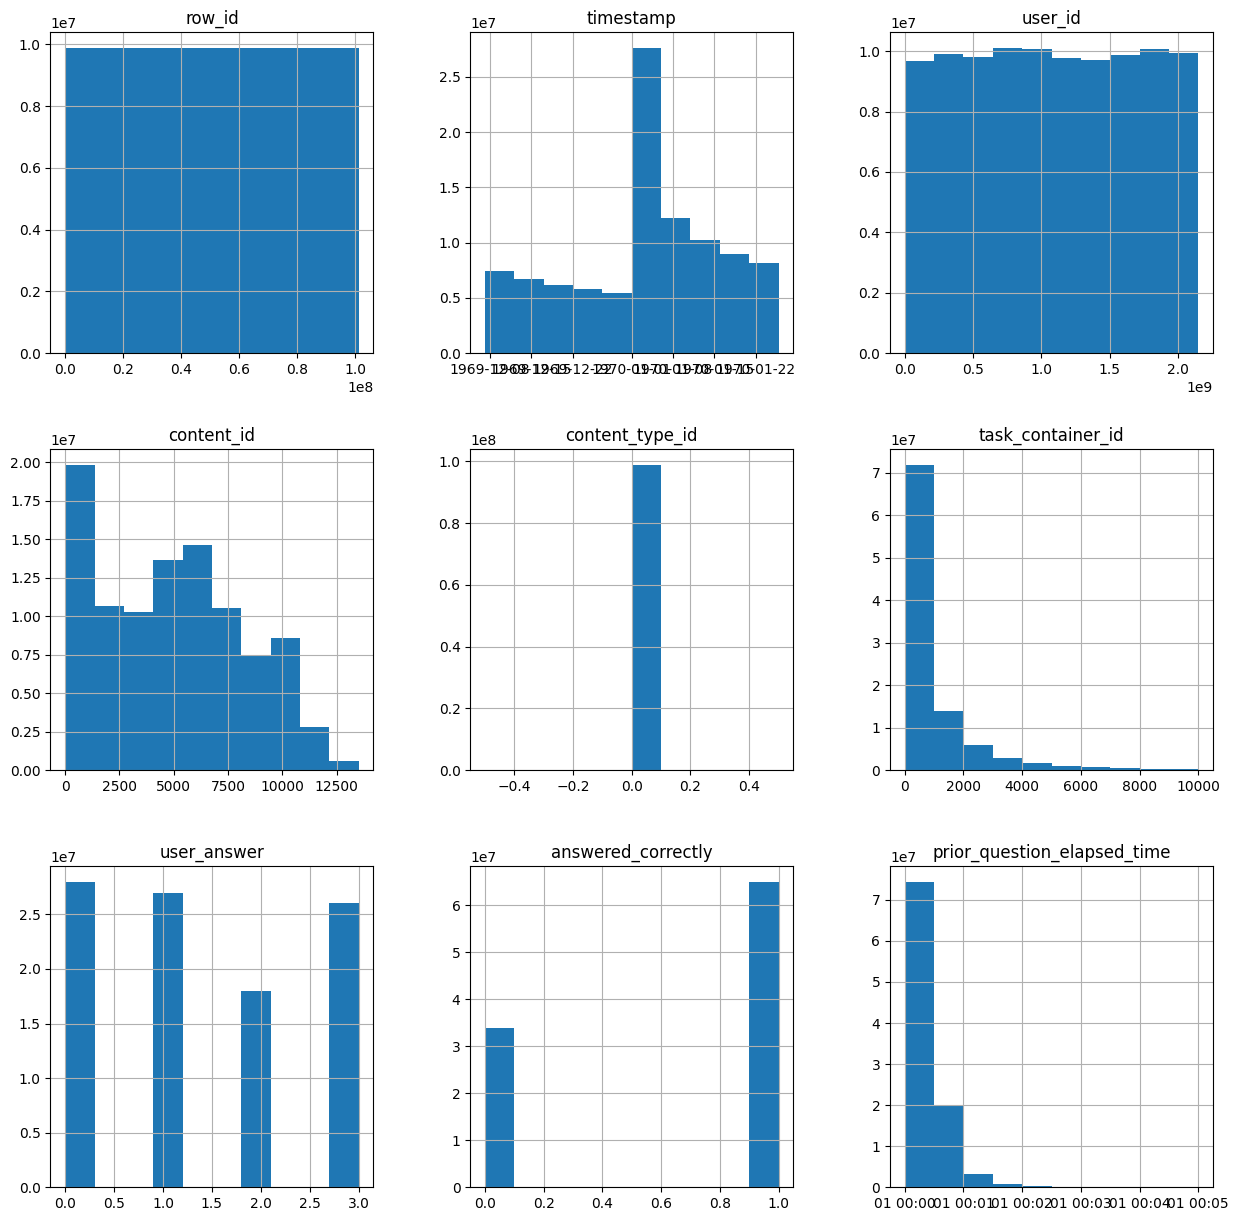

In [33]:
train.hist(figsize=(15, 15));

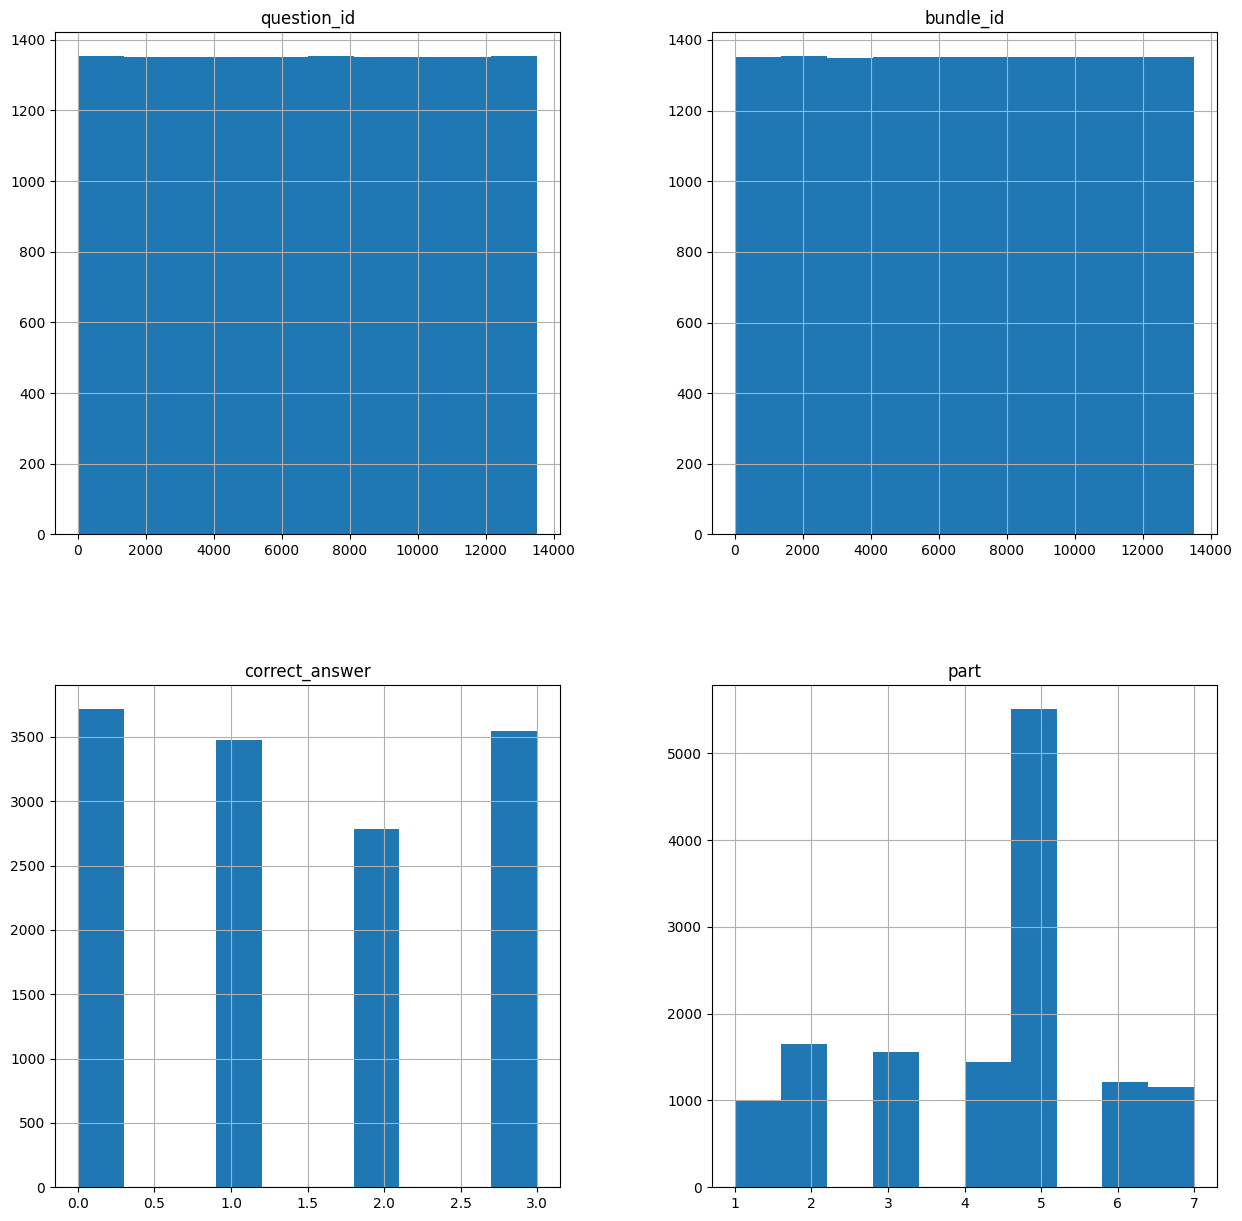

In [34]:
questions.hist(figsize=(15, 15));

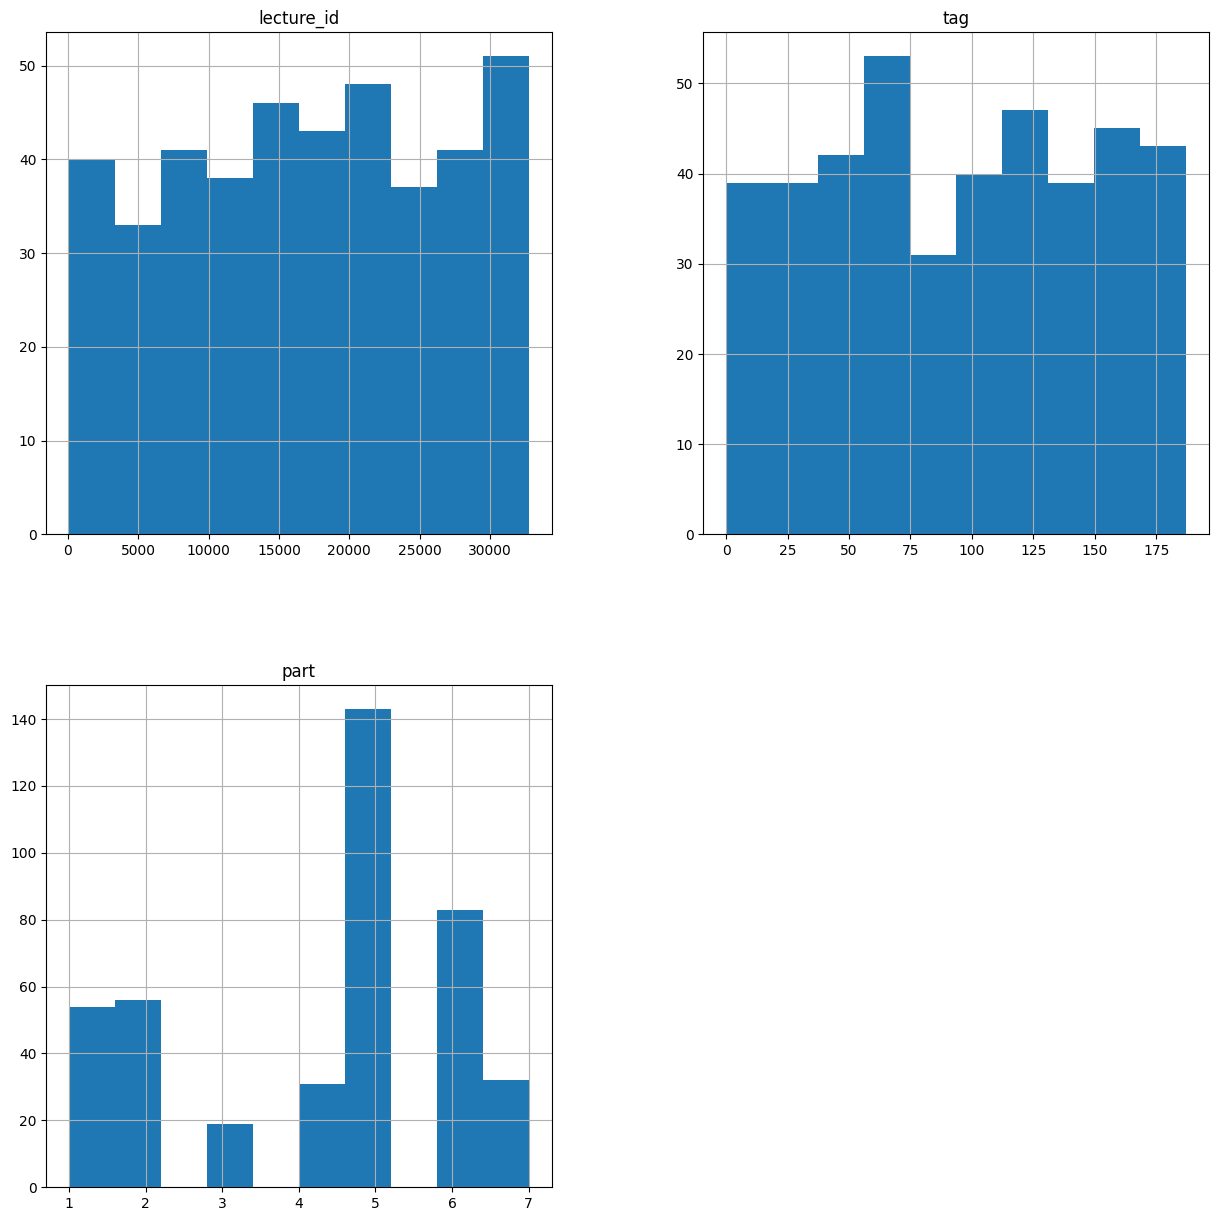

In [35]:
lectures.hist(figsize=(15, 15));

### Исследование данных

In [36]:
# Проверка уникальных значений для категориальных переменных
display(train['content_type_id'].value_counts())

content_type_id
0    98878794
Name: count, dtype: int64

In [37]:
train['user_id'].nunique() #уникальные значения

393569

In [38]:
train['content_id'].nunique()

13523

In [39]:
# Группировка по user_id для анализа успеваемости
user_performance = train.groupby('user_id').agg({
    'answered_correctly': 'mean',
    'prior_question_elapsed_time': 'mean',
    'prior_question_had_explanation': 'mean'
}).reset_index()

In [40]:
# Переименование столбцов для удобства
user_performance.columns = ['user_id', 'average_correctness', 'average_elapsed_time', 'explanation_seen_ratio']

In [41]:
# Вывод результатов
display(user_performance.describe())

,user_id,average_correctness,average_elapsed_time,explanation_seen_ratio
count,3.935690e+05,393569.000000,393569,393569.000000
mean,1.076369e+09,0.541118,1970-01-01 00:00:23.893674476,0.566426
min,1.150000e+02,0.000000,1970-01-01 00:00:00,0.000000
25%,5.387605e+08,0.428571,1970-01-01 00:00:19.114583333,0.230769
50%,1.077746e+09,0.566667,1970-01-01 00:00:22.722650549,0.655172
75%,1.613547e+09,0.666667,1970-01-01 00:00:27.308993138,0.904110
max,2.147483e+09,1.000000,1970-01-01 00:03:50.833333333,1.000000
std,6.201310e+08,0.168161,NaN,0.360063


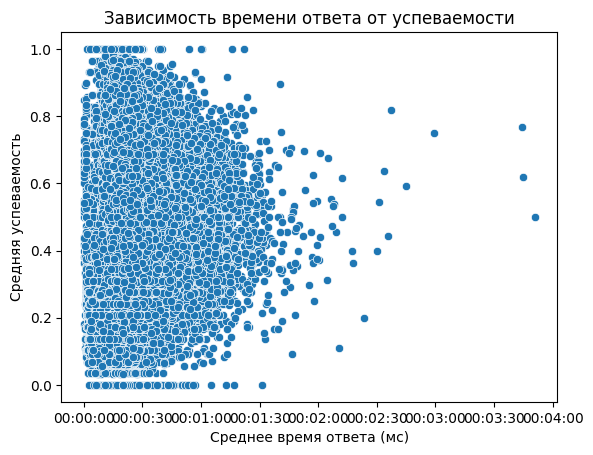

In [42]:
# Визуализация зависимости между временем ответа и успеваемостью
sns.scatterplot(data=user_performance, x='average_elapsed_time', y='average_correctness')
plt.title('Зависимость времени ответа от успеваемости')
plt.xlabel('Среднее время ответа (мс)')
plt.ylabel('Средняя успеваемость')
plt.show()

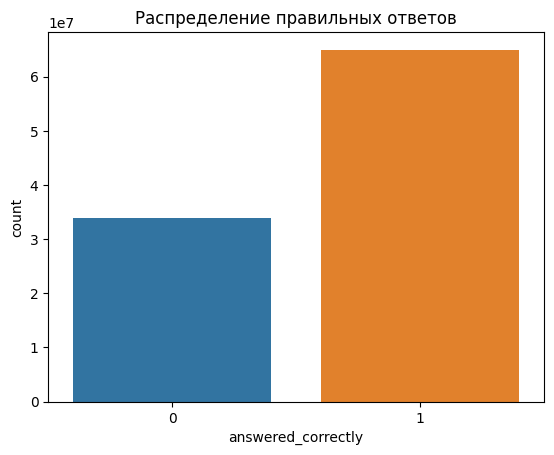

In [43]:
# Распределение правильных ответов
sns.countplot(x='answered_correctly', data=train)
plt.title('Распределение правильных ответов')
plt.show()

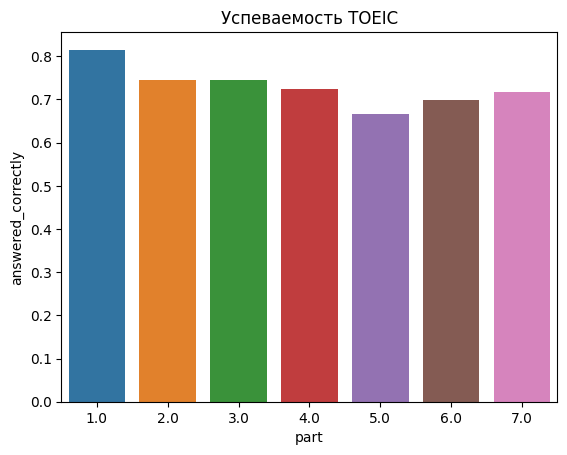

In [44]:
# Успеваемость по вопросам
question_performance = train[train['content_type_id'] == 0].groupby('content_id')['answered_correctly'].mean().reset_index()
question_performance = question_performance.merge(questions[['question_id', 'part']], left_on='content_id', right_on='question_id', how='left')

# Успеваемость по частям теста
part_performance = question_performance.groupby('part')['answered_correctly'].mean().reset_index()
sns.barplot(x='part', y='answered_correctly', data=part_performance)
plt.title('Успеваемость TOEIC')
plt.show()

In [45]:
app = dash.Dash(__name__)

# Определяем макет приложения
app.layout = html.Div([
    html.H1("Анализ успеваемости студентов", style={'textAlign': 'center'}),
    
    # Выпадающий список для выбора типа контента
    dcc.Dropdown(
        id='content-type-dropdown',
        options=[
            {'label': 'Все', 'value': 'all'},
            {'label': 'Вопросы', 'value': 0},
            {'label': 'Лекции', 'value': 1}
        ],
        value='all',
        clearable=False,
        style={'width': '50%', 'margin': 'auto'}
    ),
    
    # График успеваемости пользователей
    dcc.Graph(id='performance-graph'),
    
    html.H2("Корреляция между переменными", style={'textAlign': 'center'}),
    dcc.Graph(id='correlation-heatmap')
])
# Декоратор, который связывает входные и выходные компоненты Dash-приложения.
@app.callback(
    Output('performance-graph', 'figure'),
    Input('content-type-dropdown', 'value')
)
def update_performance_graph(selected_content):
    """
    Обновляет график успеваемости в зависимости от выбранного типа контента.
    """
    # Фильтруем данные в зависимости от выбранного типа контента
    if selected_content == 'all':
        filtered_df = train
    else:
        filtered_df = train[train['content_type_id'] == selected_content]
    
    # Вычисляем среднюю успеваемость пользователей
    performance = filtered_df.groupby('user_id')['answered_correctly'].mean().reset_index()
    
    # Создаем гистограмму успеваемости
    fig = px.histogram(performance, x='answered_correctly', nbins=20,
                       title='Успеваемость пользователей',
                       labels={'answered_correctly': 'Средняя успеваемость'},
                       color_discrete_sequence=['#636EFA'])  # Задаем цвет
    
    return fig
# Декоратор, который связывает входные и выходные компоненты Dash-приложения.
@app.callback(
    Output('correlation-heatmap', 'figure'),
    Input('content-type-dropdown', 'value')
)
def update_correlation_heatmap(selected_content):
    """
    Обновляет тепловую карту корреляции в зависимости от выбранного типа контента.
    """
    # Фильтруем данные в зависимости от выбранного типа контента
    if selected_content == 'all':
        filtered_df = train
    else:
        filtered_df = train[train['content_type_id'] == selected_content]
    
    # Вычисляем корреляцию с помощью метода corr()
    correlation_matrix = filtered_df.corr()

    # Создаем тепловую карту корреляции
    fig = px.imshow(correlation_matrix, title="Корреляция между переменными",
                    color_continuous_scale='Viridis',
                    labels=dict(x="Переменные", y="Переменные", color="Корреляция"),
                    aspect="auto")  # Устанавливаем соотношение сторон
    
    return fig

In [46]:
if __name__ == '__main__':
    app.run_server(debug=True, port=8027)